In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
# Please remember this function, it is a must!
def try_gpu(i=0):
  if torch.cuda.device_count() >= i+1:
    return torch.device(f'cuda:{i}')
  return torch.device('cpu')

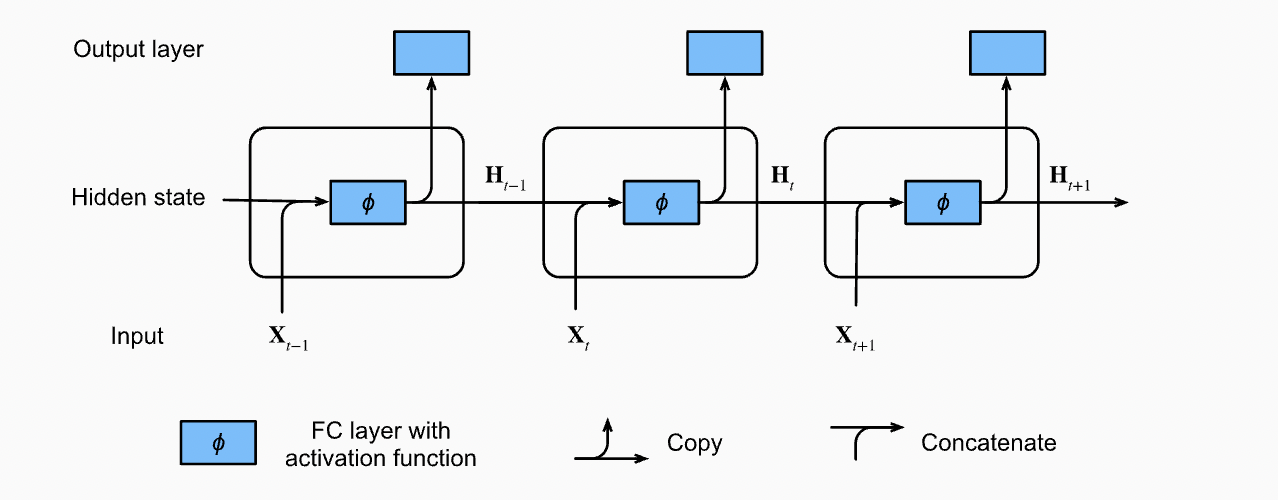

$$
\mathbf{H}_t=\phi\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xh}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hh}}+\mathbf{b}_{\mathrm{h}}\right)
$$.
$$
\mathbf{O}_t=\mathbf{H}_t \mathbf{W}_{\mathrm{hq}}+\mathbf{b}_{\mathrm{q}}
$$

The data format input into RNN is (time step, batch, features). From the picture below we can know why this is done!

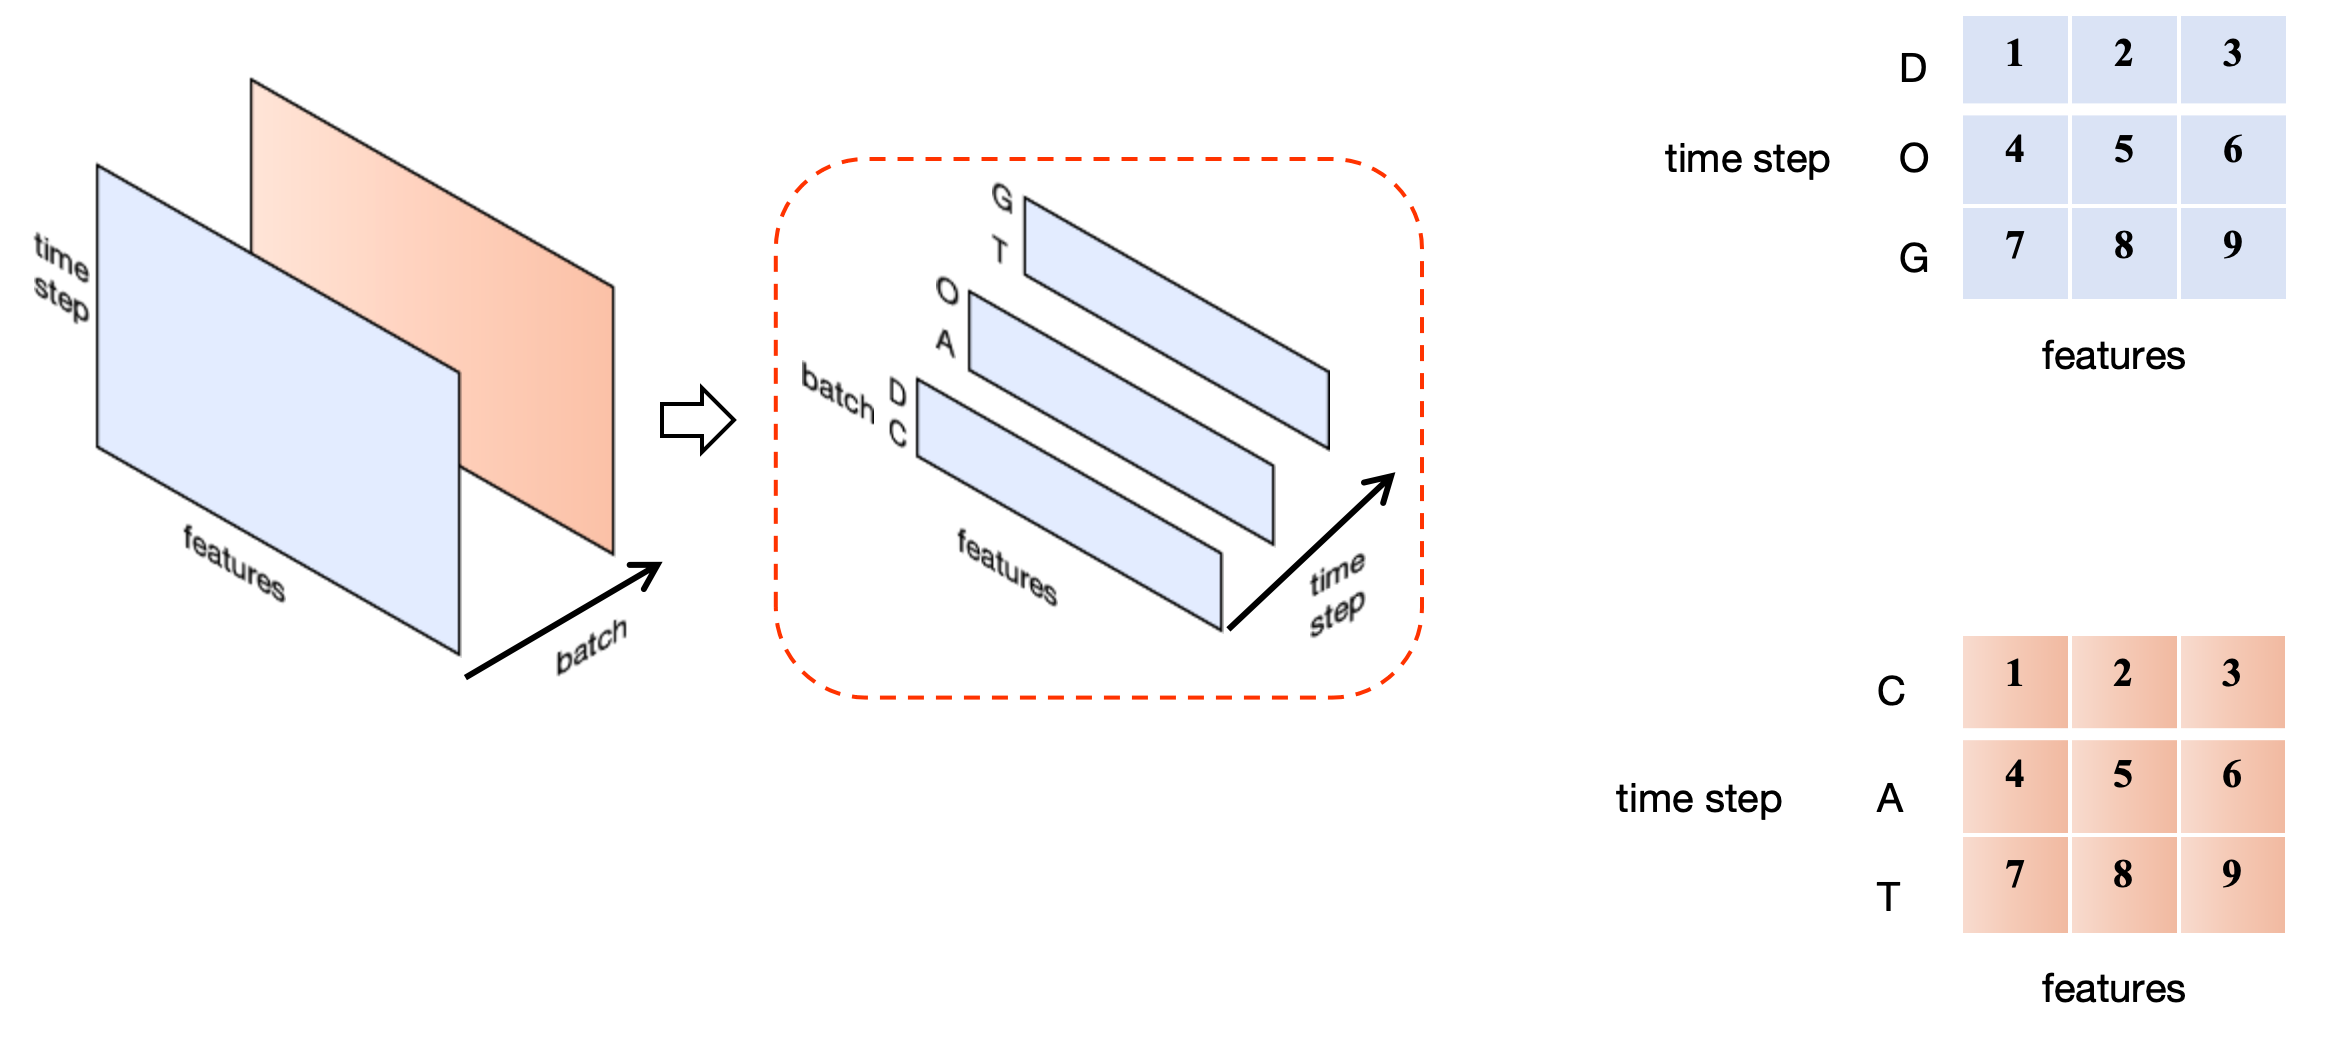

In [3]:
# Define the parameters required for the RNN!
def get_params(input, num_hiddens, output, device):
  W_xh = torch.normal(0, 0.01, size=(input, num_hiddens), device=device)
  W_hh = torch.normal(0, 0.01, size=(num_hiddens, num_hiddens), device=device)
  W_hq = torch.normal(0, 0.01, size=(num_hiddens, output), device=device)
  b_h = torch.zeros((num_hiddens), device=device)
  b_q = torch.zeros((output), device=device)
  params = [W_xh, W_hh, W_hq, b_h, b_q]
  for param in params:
    param.requires_grad_(True)
  return params

In [4]:
def init_state(batch_size, num_hiddens, device):
  return (torch.zeros((batch_size, num_hiddens), device=device), ) # For subsequent LSTM

In [5]:
def rnn(X, state, params):
  W_xh, W_hh, W_hq, b_h, b_q = params
  # The shape of X is (time_step, batch_size, features)
  H, = state
  outputs = []
  for x in X:
    H = torch.tanh(torch.mm(x, W_xh) + torch.mm(H, W_hh) + b_h)
    O = torch.mm(H, W_hq) + b_q
    outputs.append(O)
    # The outputs at this time include the output at each moment.
    # In the graph classification task, we only need the output at the last moment!
  return outputs[-1], (H, )

In [6]:
# Package the above functions
class RNN(nn.Module):
  def __init__(self, input, num_hiddens, output, batch_size, forward, init, device):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.params = get_params(input, num_hiddens, output, device)
    self.init = init
    self.forward = forward


  def __call__(self, x, state):
    # The shape of x is (batch_size, channels, width, length)
    shape = x.shape
    # The picture can be seen as a very long sequence!
    x = x.reshape(shape[0], -1, shape[-1])
    x = x.permute(1, 0, 2)
    return self.forward(x, state, self.params)

  def init_state_(self, batch, device):
    return self.init(batch, self.num_hiddens, device)



In [ ]:
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                                        transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                                       transform=transforms.ToTensor())

In [8]:
from Common import plot_loss_acc, validation_rnn, train_and_test_rnn

In [13]:
num_epochs = 50
batch_size = 256
lr = 0.001

In [14]:
net = RNN(28, 128, 10, batch_size, rnn, init_state, try_gpu())
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.params, lr)

In [15]:
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

Step:100/235, Epoch:1/50, Loss:1.5428
Step:200/235, Epoch:1/50, Loss:1.5834
Step:235/235, Epoch:1/50, Accuracy:0.40
Step:100/235, Epoch:2/50, Loss:1.3984
Step:200/235, Epoch:2/50, Loss:1.4430
Step:235/235, Epoch:2/50, Accuracy:0.46
Step:100/235, Epoch:3/50, Loss:1.3607
Step:200/235, Epoch:3/50, Loss:1.2692
Step:235/235, Epoch:3/50, Accuracy:0.55
Step:100/235, Epoch:4/50, Loss:1.0874
Step:200/235, Epoch:4/50, Loss:1.1219
Step:235/235, Epoch:4/50, Accuracy:0.58
Step:100/235, Epoch:5/50, Loss:1.1540
Step:200/235, Epoch:5/50, Loss:1.0626
Step:235/235, Epoch:5/50, Accuracy:0.55
Step:100/235, Epoch:6/50, Loss:0.8705
Step:200/235, Epoch:6/50, Loss:1.1790
Step:235/235, Epoch:6/50, Accuracy:0.65
Step:100/235, Epoch:7/50, Loss:1.0115
Step:200/235, Epoch:7/50, Loss:0.8158
Step:235/235, Epoch:7/50, Accuracy:0.71
Step:100/235, Epoch:8/50, Loss:0.8050
Step:200/235, Epoch:8/50, Loss:0.8557
Step:235/235, Epoch:8/50, Accuracy:0.77
Step:100/235, Epoch:9/50, Loss:0.6506
Step:200/235, Epoch:9/50, Loss:0.6

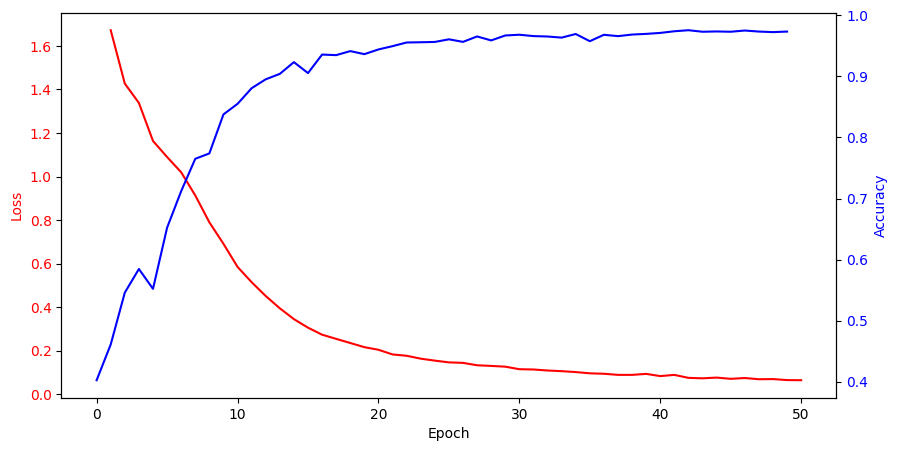

In [16]:
train_and_test_rnn(num_epochs, net, loss, optimizer, validation_rnn, train_loader,
                   test_loader, try_gpu(), figsize=(10, 5))